<a href="https://colab.research.google.com/github/lalit527/DL/blob/master/Deep_Learning_Day1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Below Cells are required to run in Google Collab

In [ ]:
# !pip install fastai==0.7.0
# !{sys.executable} -m pip install torchtext==0.2.3
# !curl http://files.fast.ai/data/dogscats.zip --output sample_data/dogscats.zip
# !unzip sample_data/dogscats.zip  

In [1]:
import fastai

In [18]:
from fastai.imports import *

In [16]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [ ]:
PATH = "dogscats/"
sz = 224

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
os.listdir(PATH)

['valid', 'train', 'models', 'test1', 'sample']

In [8]:
os.listdir(f'{PATH}valid')

['dogs', 'cats']

In [9]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.6008.jpg',
 'cat.2705.jpg',
 'cat.12282.jpg',
 'cat.11040.jpg',
 'cat.6535.jpg']

In [ ]:
sns.set_style('whitegrid')

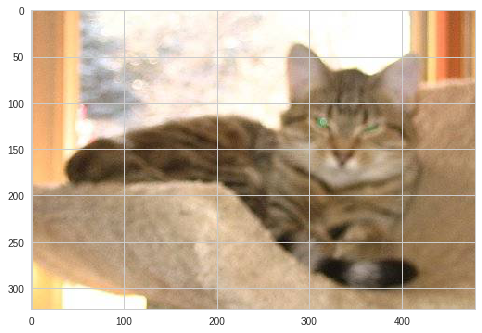

In [14]:
img = plt.imread(f'{PATH}valid/cats/{files[1]}')
plt.imshow(img);

In [15]:
img.shape

(323, 480, 3)

In [16]:
img[:4, :4]

array([[[158, 110,  62],
        [170, 122,  74],
        [188, 137,  90],
        [199, 147, 100]],

       [[184, 136,  88],
        [190, 142,  94],
        [200, 149, 102],
        [202, 150, 103]],

       [[189, 141,  93],
        [192, 144,  96],
        [198, 147, 100],
        [198, 146,  99]],

       [[181, 133,  85],
        [184, 136,  88],
        [190, 139,  92],
        [193, 141,  94]]], dtype=uint8)

In [17]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 65723850.54it/s]


100%|██████████| 32/32 [00:14<00:00,  4.20it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.047396   0.02651    0.9905    
    1      0.039142   0.027538   0.9885    



[array([0.02754]), 0.9885]

In [18]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [19]:
data.classes

['cats', 'dogs']

In [20]:
data

In [21]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [22]:
log_preds[:10]

array([[ -0.00023,  -8.37111],
       [ -0.00016,  -8.73412],
       [ -0.0001 ,  -9.20283],
       [ -0.00002, -10.80938],
       [ -0.0003 ,  -8.12568],
       [ -0.00021,  -8.44963],
       [ -0.00064,  -7.34731],
       [ -0.00001, -12.12615],
       [ -0.01143,  -4.47754],
       [ -0.20849,  -1.6703 ]], dtype=float32)

In [ ]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:, 1])

In [ ]:
def rand_by_mask(mask): 
  return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)

def rand_by_correct(is_correct):
  return rand_by_mask((preds == data.val_y) == is_correct)

In [ ]:
def plots(ims, figsize=(12, 6), rows=1, titles=None):
  f = plt.figure(figsize=figsize)
  for i in range(len(ims)):
    sp = f.add_subplot(rows, len(ims) // rows, i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i], fontsize=16)
    plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, idx):
  return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
  imgs = [load_img_id(data.val_ds, x) for x in idxs]
  title_probs = [probs[x] for x in idxs]
  print(title)
  return plots(imgs, rows=1, titles=title_probs, figsize=(16, 8)) if len(imgs) > 0 else print('Not Found')

Correctly classified


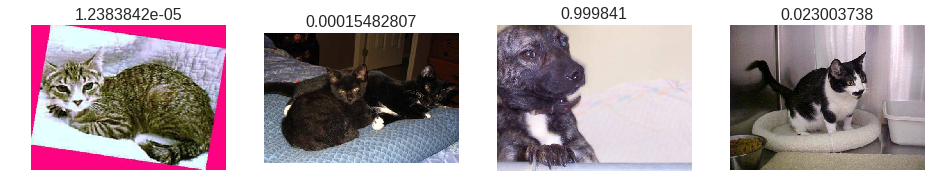

In [27]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


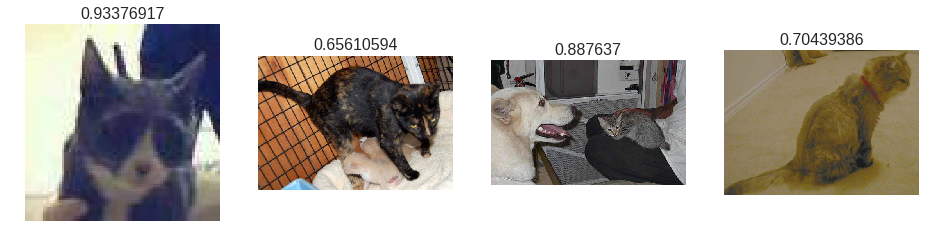

In [28]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
def most_by_mask(mask, mult):
  idxs = np.where(mask)[0]
  return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
  mult = -1 if(y==1)==is_correct else 1
  return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


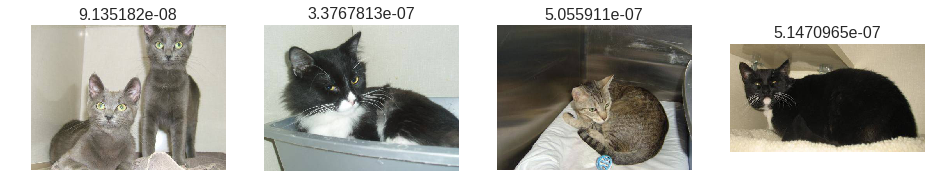

In [30]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


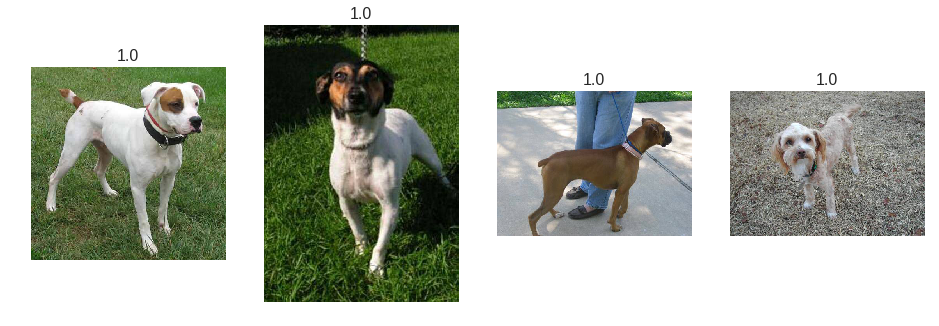

In [31]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


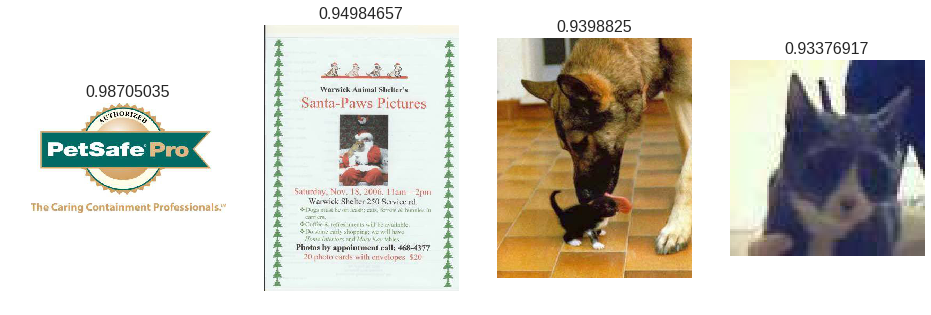

In [32]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


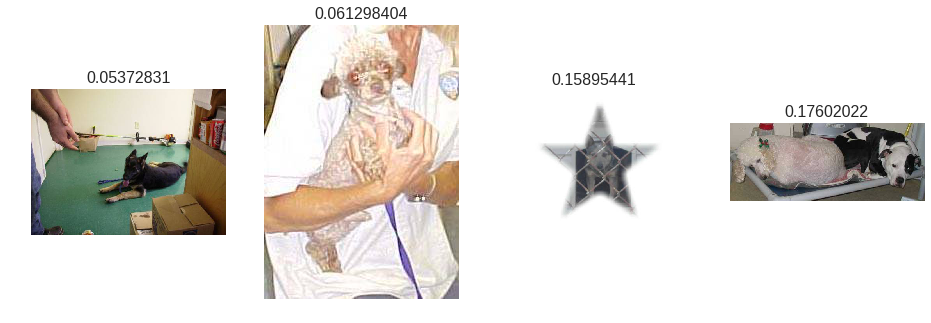

In [33]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


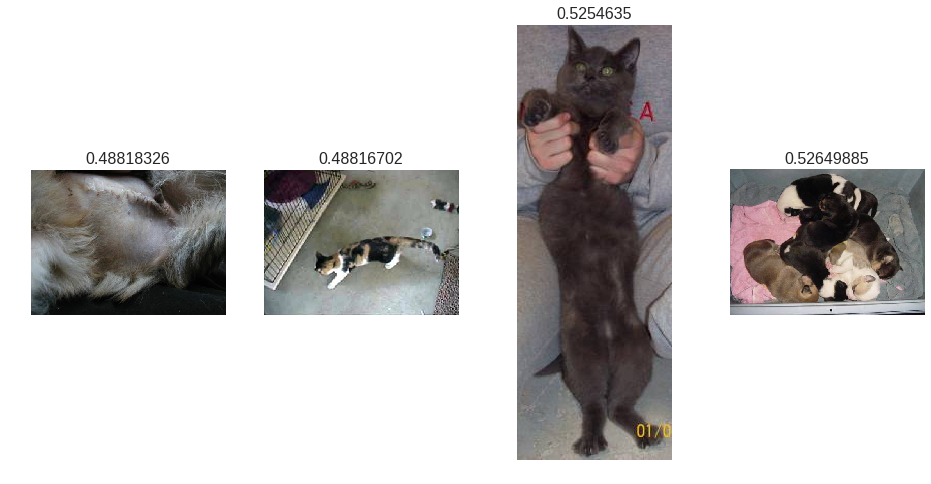

In [34]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [36]:
lrf=learn.lr_find()

 85%|████████▌ | 306/360 [00:07<00:01, 51.45it/s, loss=0.378]


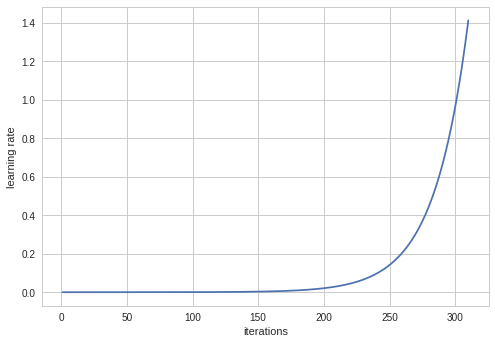

In [37]:
learn.sched.plot_lr()

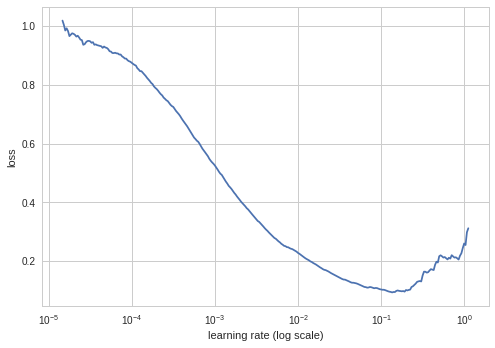

In [38]:
learn.sched.plot()

In [40]:
arch = resnet34
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy   
    0      0.043807   0.026461   0.9905    



[array([0.02646]), 0.9905]